In [1]:
%pip install --upgrade  langchain langchain-google-genai "langchain[docarray]" faiss-cpu pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 815.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.2 MB/s eta 0:00:00
  Created wheel for hnswlib: filename=hnswlib-0

In [2]:
import os
import requests
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

In [6]:
from langchain.vectorstores import DocArrayInMemorySearch

In [7]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [9]:
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader

In [10]:
from langchain_text_splitters import CharacterTextSplitter

In [11]:
from langchain_community.vectorstores import FAISS

In [12]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [13]:
def load_model(model_name):
  if model_name=="gemini-pro":
    llm = ChatGoogleGenerativeAI(model="gemini-pro")
  else:
    llm=ChatGoogleGenerativeAI(model="gemini-pro-vision")

  return llm


In [14]:
model_text=load_model("gemini-pro")

In [18]:
model_text.invoke("please come up with the best funny line.").content

'"Why did the scarecrow win an award? Because he was outstanding in his field!"'

In [19]:
model_text(
    [
        HumanMessage(content="Answer with Simple 'Yes' or 'No'. Question: Is apple a Fruit?")
    ]
).content

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'Yes'

In [20]:
def get_image(url,filename,extension):
  content = requests.get(url).content
  with open(f'/content/{filename}.{extension}', 'wb') as f:
    f.write(content)
  image = Image.open(f"/content/{filename}.{extension}")
  image.show()
  return image



In [21]:
image = get_image("https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/1705ca64-fbc8-4b79-a451-4ab77760c219/dunk-low-older-shoes-C7T1cx.png",
                  "nike-shoes",
                  "png")

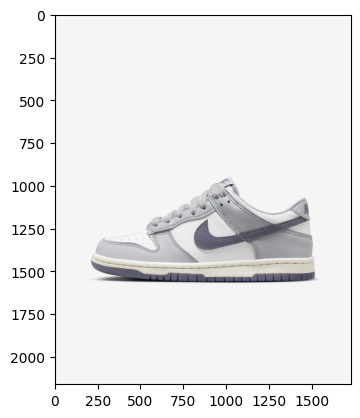

In [22]:
plt.imshow(image)
plt.show()

In [23]:
vision_model=load_model("gemini-pro-vision")

In [29]:
prompt="give me summary of this image in 5 words"

In [30]:
message= HumanMessage(
    content=[
         {
            "type": "text",
            "text": prompt,
        },
        {

            "type": "image_url", "image_url": image
        }
    ]
)

In [31]:
print(vision_model.invoke([message]).content)

 A gray and white Nike Dunk Low.


In [32]:
loader = TextLoader("/content/nike_shoes.txt")
print(loader.load()[0].page_content)

Nike Air Max Plus sneakers. They feature a brown upper with a black Nike Swoosh logo on the side and a visible Air Max unit in the heel. The sole is white.
Here are some more details about the Nike Air Max Plus:
Style: TN
Release date: January 1, 2017
Style code: 852630-300
Original retail price: $150 USD
The Air Max Plus, also known as the TN, is a popular Nike running shoe that was first released in 1998. It is known for its unique design, which includes a gradient upper, visible Air Max units, and a wavy outsole. The TN has been a popular shoe among sneakerheads and casual wearers alike for over two decades.
It features a brown upper with a black Swoosh logo and a white sole. The shoe is currently available for resale on the StockX marketplace for an average price of around $150 USD.
Nike Air Max Plus Store Location: "Kings Way, Kathmandu, Nepal".
\n\n\n



Nike Dunk Low Retro sneakers.
Here are some more details about the Nike Dunk Low Retro:
Style: Low-top
Release date: October 31

In [36]:
text=loader.load()[0].page_content

In [37]:
def get_text_chunks_langchain(text):
  text_splitter = CharacterTextSplitter(chunk_size=20, chunk_overlap=10)
  docs = [Document(page_content=x) for x in text_splitter.split_text(text)]
  return docs

In [38]:
docs = get_text_chunks_langchain(text)

In [39]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [40]:
vectorstore = FAISS.from_documents(docs,embedding=embeddings)

In [41]:
retriever=vectorstore.as_retriever()

In [42]:
retriever.invoke("Nike slide/sandal.")

[Document(page_content='Nike slide/sandal.\nThey appear to be the Nike Slide/Sandal, which is a unisex slide/sandal.\nHere are some of the features:\nSoft, one-piece upper: The upper is made of a soft, synthetic material that provides comfort and support.\nPhylon midsole: The midsole is made of Phylon, which provides cushioning and support.\nRubber outsole: The outsole is made of rubber for traction and durability.\nSwoosh logo: The Nike Swoosh logo is on the strap of the sandal.\nAvailable in a variety of colors: The Nike Benassi Solarsoft Sandal is available in a variety of colors, including black, white, and beige.\nNike off courte slides store location: "Bhaktapur, Nepal".'),
 Document(page_content='Nike Dunk Low Retro sneakers.\nHere are some more details about the Nike Dunk Low Retro:\nStyle: Low-top\nRelease date: October 31, 2020\nStyle code: DD1391-100\nOriginal retail price: $100 USD\nThe Dunk Low Retro is a popular Nike skateboarding shoe that was first released in 1985. It 

In [43]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [44]:
llm_vision = load_model("gemini-pro-vision")

In [47]:
llm_text = load_model("gemini-pro")

In [50]:
template = """
```
{context}
```

{query}


Provide brief information and store location.
"""

In [51]:
prompt = ChatPromptTemplate.from_template(template)

In [52]:
rag_chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt
    | llm_text
    | StrOutputParser()
)

In [53]:
result = rag_chain.invoke("can you give me a detail of nike sandal?")

In [54]:
display(Markdown(result))

**Nike Benassi Solarsoft Sandal**

**Features:**

* Soft, one-piece upper for comfort and support
* Phylon midsole for cushioning and support
* Rubber outsole for traction and durability
* Swoosh logo on the strap
* Available in a variety of colors

**Store Location:** "Bhaktapur, Nepal"

In [55]:
rag_chain

{
  context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7d2b6e953e80>),
  query: RunnablePassthrough()
}
| ChatPromptTemplate(input_variables=['context', 'query'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], template='\n```\n{context}\n```\n\n{query}\n\n\nProvide brief information and store location.\n'))])
| ChatGoogleGenerativeAI(model='gemini-pro', client=genai.GenerativeModel(
      model_name='models/gemini-pro',
      generation_config={},
      safety_settings={},
      tools=None,
      system_instruction=None,
  ))
| StrOutputParser()

In [56]:
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

In [ ]:
full_chain

In [57]:
url_1 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/252f2db6-d426-4931-80a0-8b7f8f875536/calm-slides-K7mr3W.png"

In [58]:
image = get_image(url_1, "nike3", "png")

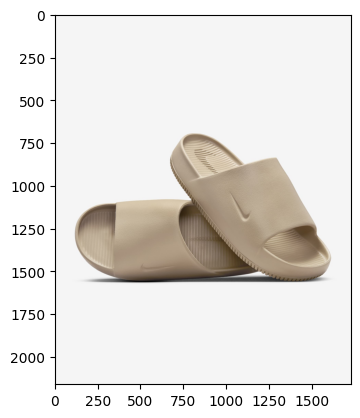

In [59]:
plt.imshow(image)
plt.show()

In [63]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Provide information on given sandle image Brand and model.",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": image},
    ]
)


In [64]:
result = full_chain.invoke([message])

In [65]:
display(Markdown(result))

**Nike Offcourt Slide Sandal**

* Soft, durable foam upper
* Contoured footbed for arch support and cushioning
* Rubber outsole for traction and durability
* Available in a variety of colors
* **Store Location:** Bhaktapur, Nepal